<a href="https://colab.research.google.com/github/SahilBeniwal22/Projects/blob/main/coin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data, feature='Close'):
    data = data[['Date', feature]]
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(scaled_data, time_step=1):
    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        a = scaled_data[i:(i + time_step), 0]
        X.append(a)
        y.append(scaled_data[i + time_step, 0])
    return np.array(X), np.array(y)


In [5]:
import zipfile
import pandas as pd

zip_path = "/content/price.zip"  # Ensure this is the correct path to your uploaded ZIP file

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List all files in the ZIP archive
    file_list = zip_ref.namelist()
    print("Files in ZIP:", file_list[:10])  # Display first 10 files

    # Read the first CSV file without extracting
    first_file = file_list[0]  # Choose any file from the list
    with zip_ref.open(first_file) as file:
        df = pd.read_csv(file)  # Read CSV directly
        print(df.head())  # Display first few rows


Files in ZIP: ['Top 100 Crypto Coins/1inch.csv', 'Top 100 Crypto Coins/Aave.csv', 'Top 100 Crypto Coins/Algorand.csv', 'Top 100 Crypto Coins/ApeCoin.csv', 'Top 100 Crypto Coins/Arweave.csv', 'Top 100 Crypto Coins/Axie Infinity.csv', 'Top 100 Crypto Coins/BNB.csv', 'Top 100 Crypto Coins/Basic Attention Token.csv', 'Top 100 Crypto Coins/Binance USD.csv', 'Top 100 Crypto Coins/BitTorrent (New).csv']
         Date      Open      High       Low     Close       Volume Currency
0  2020-12-25  1.602781  2.918094  1.375262  2.328544  638225549.0      USD
1  2020-12-26  2.318946  2.434916  1.582264  1.596896  237653073.0      USD
2  2020-12-27  1.597744  1.630781  1.056657  1.062112  183978307.0      USD
3  2020-12-28  1.064454  1.254447  1.049051  1.110076  119337529.0      USD
4  2020-12-29  1.110460  1.111282  0.761151  0.887798  137916899.0      USD


In [6]:
def process_all_files(zip_path):
    """Reads and processes all CSV files inside the ZIP without extracting."""
    all_data = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        csv_files = [file for file in zip_ref.namelist() if file.endswith('.csv')]

        for file in csv_files:
            with zip_ref.open(file) as f:
                df = pd.read_csv(f)
                print(f"Processing: {file}")
                print(df.head())  # Display first few rows for verification
                all_data.append(df)

    return all_data

# Call function to process all files
all_datasets = process_all_files(zip_path)
print(f"Processed {len(all_datasets)} CSV files.")


Processing: Top 100 Crypto Coins/1inch.csv
         Date      Open      High       Low     Close       Volume Currency
0  2020-12-25  1.602781  2.918094  1.375262  2.328544  638225549.0      USD
1  2020-12-26  2.318946  2.434916  1.582264  1.596896  237653073.0      USD
2  2020-12-27  1.597744  1.630781  1.056657  1.062112  183978307.0      USD
3  2020-12-28  1.064454  1.254447  1.049051  1.110076  119337529.0      USD
4  2020-12-29  1.110460  1.111282  0.761151  0.887798  137916899.0      USD
Processing: Top 100 Crypto Coins/Aave.csv
         Date       Open       High        Low      Close    Volume Currency
0  2020-10-02   0.000000   0.516571   0.000000   0.516571       0.0      USD
1  2020-10-03   0.523836  65.305939   0.523801  53.151489       0.0      USD
2  2020-10-04  53.179859  55.070354  50.688992  52.675034       0.0      USD
3  2020-10-05  52.675034  55.112358  49.787899  53.219242       0.0      USD
4  2020-10-06  53.291969  53.402271  40.734577  42.401600  583091.0      U

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df, feature='Close', time_step=100):
    """Normalize and prepare data for LSTM."""
    df = df[['Date', feature]].dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

    return X, y, scaler

# Example: Preprocess the first dataset
df_sample = all_datasets[0]  # Selecting one dataset from the processed list
X, y, scaler = preprocess_data(df_sample)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (505, 100, 1), Shape of y: (505,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Save Model
model.save("lstm_model.h5")
print("Model training completed and saved as 'lstm_model.h5'.")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 0.0517 - val_loss: 0.0186
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0154 - val_loss: 0.0087
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0049 - val_loss: 0.0035


Model training completed and saved as 'lstm_model.h5'.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


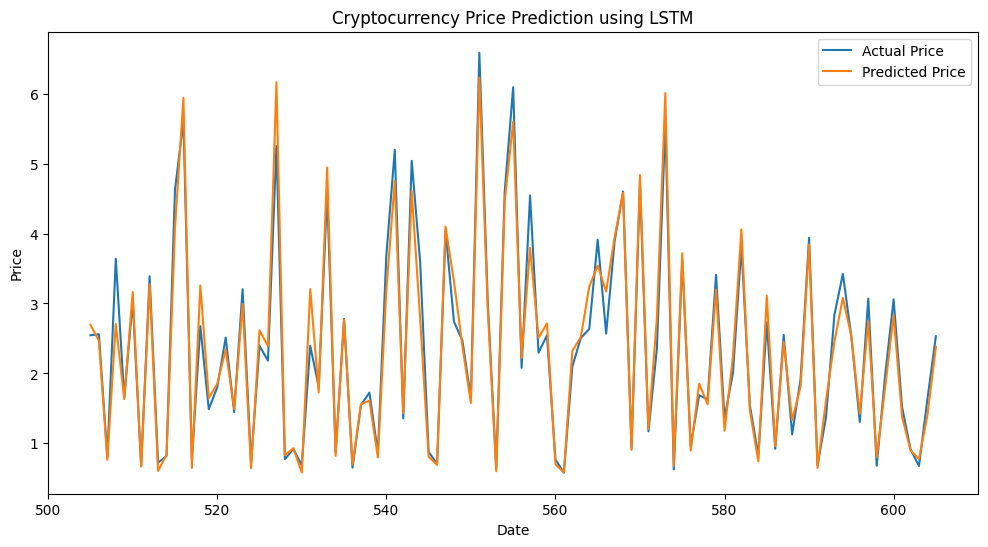

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("lstm_model.h5")

# Make Predictions
train_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_sample.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Price")
plt.plot(df_sample.index[-len(y_test):], train_predict, label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Cryptocurrency Price Prediction using LSTM")
plt.legend()
plt.show()
